# Packages

In [12]:
import math
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_vector
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.extensions import XGate
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from ibm_washington_config import coupling_map, basis_gates

# Ours

In [5]:
def project(img, h_img, w_img, h_proj, w_proj):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    print("x,y,z = ",x,y,z)
    r = 0.5
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r / (x**2 + y**2 + 4*r**2), 4)
    print("r = ", r, " k = ", k)
    k_list.append(k)
    P = np.array([k * x, k * y, (1-2*k)*r ])
    return P

In [2]:
import os
os.path.abspath('')
path_img_2 = 'pixel2x2.png'
path_img_2 = os.path.join(os.path.abspath(''),
                            path_img_2)

c:\Users\HCI\Desktop\Stereo\pixel2x2.png


In [22]:
start = time.time()

os.path.abspath('')
path_img_2 = 'pixel2x2.png'
path_img_2 = os.path.join(os.path.abspath(''),
                            path_img_2)


pix = np.array(Image.open(path_img_2))

h_img = pix.shape[0]
w_img = pix.shape[1]
h_proj_2 = 2
w_proj_2 = 2

proj_2 = np.array([[1,1,0],
                 [-1,1,0],
                 [-1,-1,0],
                 [1,-1,0]])

point_2d = []
point_3d = []
k_list = []

for i in proj_2:
    sphere = project(i,h_img, w_img, h_proj_2, w_proj_2)
    point_2d.append(i)
    point_3d.append(sphere)
    

end = time.time()

print(f"{end - start:.5f} sec")

x,y,z =  1 1 0
r =  0.5  k =  0.6667
x,y,z =  -1 1 0
r =  0.5  k =  0.6667
x,y,z =  -1 -1 0
r =  0.5  k =  0.6667
x,y,z =  1 -1 0
r =  0.5  k =  0.6667
0.00199 sec


[array([ 0.6667,  0.6667, -0.1667]), array([-0.6667,  0.6667, -0.1667]), array([-0.6667, -0.6667, -0.1667]), array([ 0.6667, -0.6667, -0.1667])]


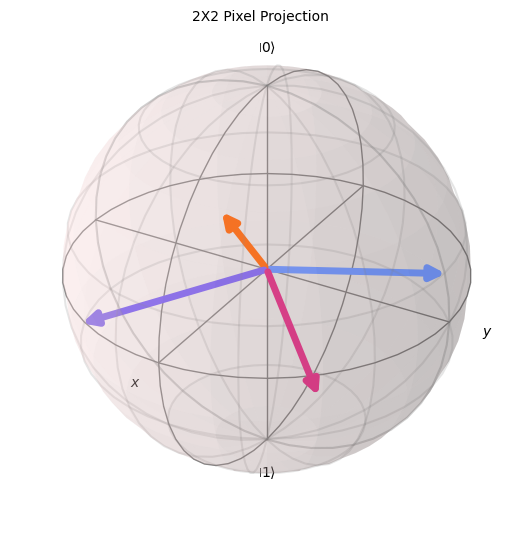

In [7]:
print(point_3d)
plot_bloch_vector(point_3d, title='2X2 Pixel Projection')

# FRQI

## Simulate FRQI in Qiskit

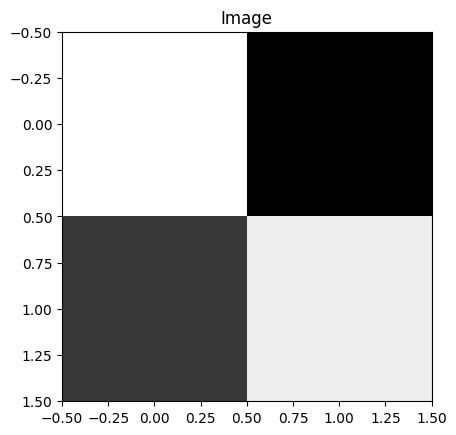

In [14]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [15]:
image

array([[207,  56],
       [ 90, 196]])

In [16]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=20000)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_13920\272954302.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


[205, 54, 87, 196] 
 [207  56  90 196]
0.81200 sec


C:\Users\HCI\AppData\Local\Temp\ipykernel_13920\272954302.py:46: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


In [17]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

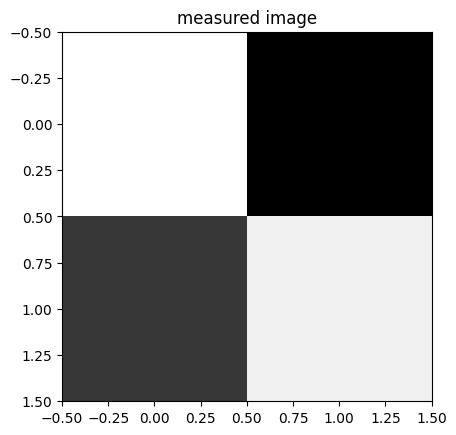

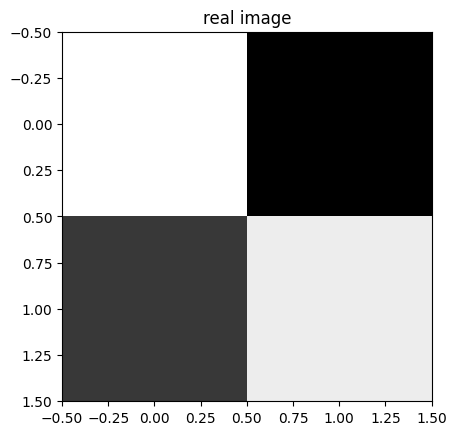

In [18]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [20]:
print("Image = ",image, "reconstructed = ",classical_colors)

Image =  [[207  56]
 [ 90 196]] reconstructed =  [205, 54, 87, 196]


## Simulate FRQI in IonQ

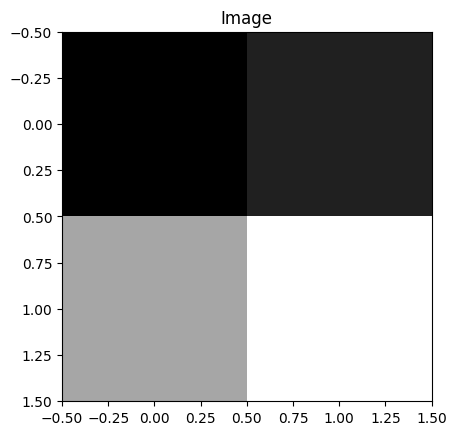

In [23]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [24]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [25]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_13920\1658588320.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


[75, 96, 182, 228] 
 [ 81 100 178 230]
8.51246 sec


In [26]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

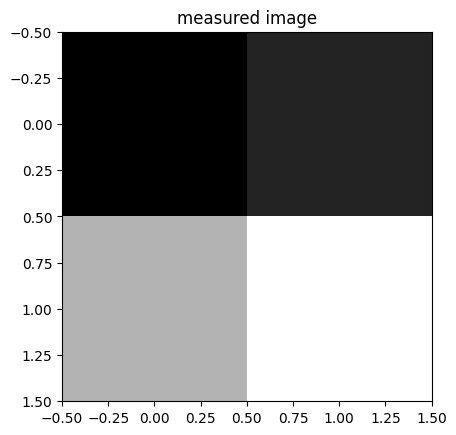

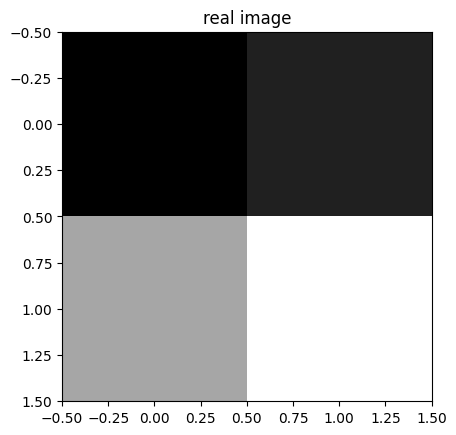

In [27]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [28]:
print("Image = ",image, "reconstructed = ",classical_colors)

Image =  [[ 81 100]
 [178 230]] reconstructed =  [75, 96, 182, 228]


# NEQR

## Simulate NEQR in Qiskit

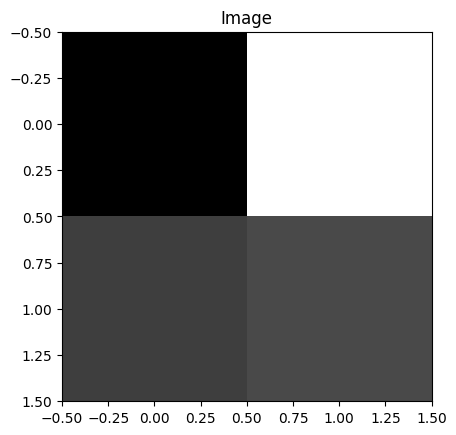

In [11]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3746219321.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)
C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3746219321.py:32: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_neqr = aer_sim.run(qobj)


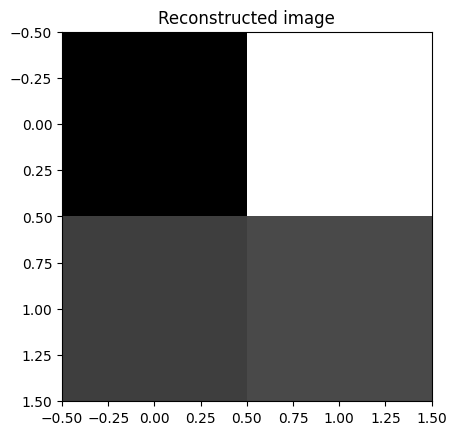

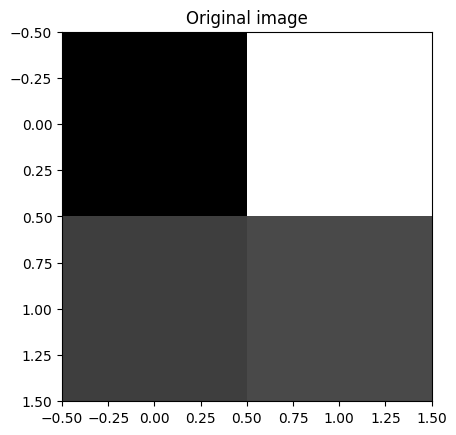

[ 42. 247.  92. 101.] 
 [ 42 247  92 101]
0.06229 sec


In [13]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))

end = time.time()

plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

In [14]:
print("Image = ",image, "reconstructed = ",out_image)

Image =  [[ 42 247]
 [ 92 101]] reconstructed =  [[ 42. 247.]
 [ 92. 101.]]


## Simulate NEQR in IonQ

In [7]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [8]:
simulator_backend = provider.get_backend("ionq_simulator")

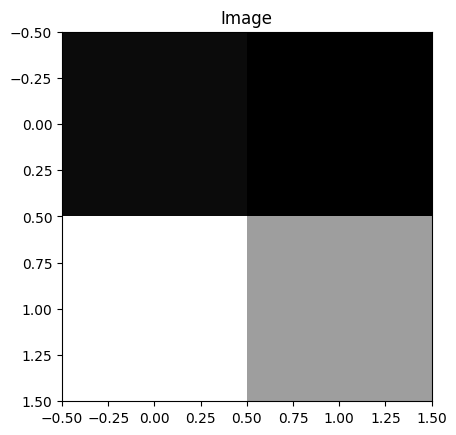

In [29]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\3770150665.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)


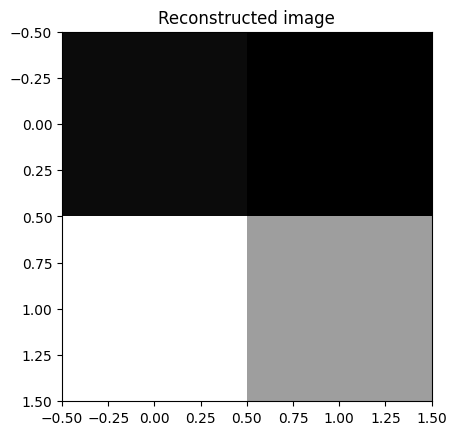

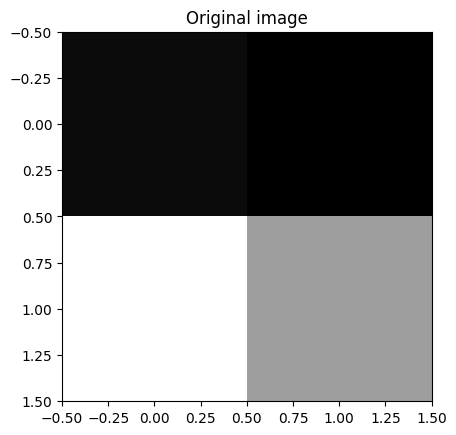

[105.  98. 248. 191.] 
 [105  98 248 191]
8.62745 sec


In [30]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)

for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))


simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_neqr = simulator_backend.run(t_qc_image)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())
end = time.time()

print(f"{end - start:.5f} sec")

In [31]:
print("Image = ",image, "reconstructed = ",out_image)

Image =  [[105  98]
 [248 191]] reconstructed =  [[105.  98.]
 [248. 191.]]
